In [1]:
#dependencies 
import numpy as np
import pandas as pd

In [2]:
#import cleaned data csv
all_wells = pd.read_csv('Cleaned_Data/well_cleaned.csv')
all_wells

,Unnamed: 0,WELL_BORE_CODE,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,FLOW_KIND,WELL_TYPE
0,15,NO 15/9-F-1 C,289.42,106.35,43.34,107.36,37.94,78.94,631.47,90439.09,0.00,production,OP
1,16,NO 15/9-F-1 C,270.24,107.64,47.17,99.19,60.76,70.63,1166.46,165720.39,0.00,production,OP
2,17,NO 15/9-F-1 C,262.84,107.87,47.73,94.60,63.05,66.05,1549.81,221707.31,0.00,production,OP
3,18,NO 15/9-F-1 C,255.53,107.97,48.53,89.99,64.55,61.41,1248.70,178063.52,0.00,production,OP
4,19,NO 15/9-F-1 C,247.20,108.05,49.84,84.78,65.72,56.15,1345.78,192602.19,0.00,production,OP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5938,8923,NO 15/9-F-15 D,194.98,106.52,31.58,15.81,49.02,1.26,144.01,23201.35,203.93,production,OP
5939,8924,NO 15/9-F-15 D,194.98,106.52,31.54,15.77,48.99,1.20,145.22,23068.07,202.93,production,OP
5940,8925,NO 15/9-F-15 D,194.32,106.52,31.52,15.70,50.10,1.28,142.74,23059.68,203.84,production,OP
5941,8926,NO 15/9-F-15 D,195.21,106.51,31.52,15.61,49.84,1.20,144.46,23090.47,202.76,production,OP


# Neural Network Analysis

### INPUTS: AVG_CHOKE_SIZE_P, AVG_WHP_P, AVG_WHT_P, BORE_OIL_VOL, BORE_GAS_VOL, BORE_WAT_VOL

In [3]:
#read in data for analysis 
X1= all_wells[["AVG_CHOKE_SIZE_P","AVG_WHP_P","AVG_WHT_P","BORE_OIL_VOL","BORE_GAS_VOL", "BORE_WAT_VOL"]]
y1= all_wells["AVG_DOWNHOLE_PRESSURE"].values.reshape(-1, 1)
print(X1.shape)

(5943, 6)


In [4]:
#split into test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42)

In [5]:
from sklearn.preprocessing import StandardScaler
# # Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
# # Transform the training and testing data using the X_scaler and y_scaler models
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [ ]:
#create the neural network
from tensorflow.keras.models import Sequential
model = Sequential()

In [ ]:
#create the model
from tensorflow.keras.layers import Dense
number_inputs = X_train.shape[1]
number_hidden_nodes = 100

model.add(Dense(units=number_hidden_nodes,
                activation='relu', input_dim=number_inputs))
model.add(Dense(number_hidden_nodes, kernel_initializer='normal',activation='relu'))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [ ]:
#metrics
# CREDIT: https://github.com/keras-team/keras/issues/7947
# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
#compile the model
from keras import losses

model.compile(loss="mean_absolute_error",
              optimizer="adam", metrics=[r_square, rmse])

In [ ]:
model.summary()

In [ ]:
#early stopping tuning #1
from keras.callbacks import EarlyStopping
es= EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,verbose=0, mode='min')
model.fit(
    X_test_scaled,
    y_test_scaled,
    epochs=100,
    shuffle=True,
    verbose=2,
    validation_split= .15,
    callbacks= [es]
)

In [ ]:
model.evaluate(X_test_scaled, y_test_scaled, batch_size=50)

In [ ]:
#early stopping tuning #2
from keras.callbacks import EarlyStopping
es= EarlyStopping(monitor='val_r_square', min_delta=0.000001, patience=5,verbose=0, mode='max')
model.fit(
    X_test_scaled,
    y_test_scaled,
    epochs=100,
    shuffle=True,
    verbose=2,
    validation_split= .15,
    callbacks= [es]
)

In [ ]:
model.evaluate(X_test_scaled, y_test_scaled, batch_size=50)

# Hyperas Tuning


In [6]:
#split into test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42)

In [7]:
from sklearn.preprocessing import StandardScaler
# # Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
# # Transform the training and testing data using the X_scaler and y_scaler models
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [8]:
#function to scale data for create model function
def data():
    #read in data for analysis 
    all_wells = pd.read_csv('Cleaned_Data/well_cleaned.csv')
    X1= all_wells[["AVG_CHOKE_SIZE_P","AVG_WHP_P","AVG_WHT_P","BORE_OIL_VOL","BORE_GAS_VOL", "BORE_WAT_VOL"]]
    y1= all_wells["AVG_DOWNHOLE_PRESSURE"].values.reshape(-1, 1)
    #split into test and train data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42)
    from sklearn.preprocessing import StandardScaler
    # # Create a StandardScater model and fit it to the training data
    X_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)
    # # Transform the training and testing data using the X_scaler and y_scaler models
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)
    
    x_train = X_train_scaled.reshape(-1,6)
    x_test = X_test_scaled.reshape(-1,6)
    y_train = y_train_scaled.reshape(-1,1)
    y_test = y_test_scaled.reshape(-1,1)
    return x_train, y_train, x_test, y_test

In [9]:
#metrics
# CREDIT: https://github.com/keras-team/keras/issues/7947
# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [10]:
#defining the create model function
exec('from __future__ import absolute_import, division, print_function')
from hyperas.distributions import uniform
from hyperopt import Trials, STATUS_OK, tpe
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils
from hyperas import optim
from hyperas.distributions import choice, uniform
from keras import backend as K

def create_model(x_train, y_train, x_test, y_test):
    print(x_train.shape)
    model= Sequential() 
    model.add(Dense(100, input_dim=x_train.shape[1], activation= 'relu'))
    model.add(Dropout({{uniform(0,.5)}}))
    model.add(Dense({{choice([50,100,200,300])}},activation= 'relu'))
    #model.add(Activation('relu'))
    model.add(Dropout({{uniform(0,.5)}}))
    model.add(Dense(1, activation= 'linear'))

    
################################################
# CREDIT: https://github.com/keras-team/keras/issues/7947
    def rmse(y_true, y_pred):
        from keras import backend
        return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
# mean squared error (mse) for regression  (only for Keras tensors)
    def mse(y_true, y_pred):
        from keras import backend
        return backend.mean(backend.square(y_pred - y_true), axis=-1)
    def r_square(y_true, y_pred):
        SS_res =  K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return ( 1 - SS_res/(SS_tot + K.epsilon()) )
#############################################

    model.compile(loss='mean_absolute_error', optimizer= 'adam', metrics=[r_square, rmse])
    from keras.utils import print_summary
    print_summary(model, line_length=None, positions=None, print_fn=None)
    result= model.fit(x_train, y_train,
                      batch_size={{choice([64,128])}},
                      epochs={{choice([50,100,150])}},
                      verbose=2,
                      validation_split =0.15)
    validation_acc= np.min(result.history['val_loss'])
    print('Lowest Validation Loss:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}   

#finding the best model
best_run, best_model= optim.minimize(model=create_model,
                                     data=data,
                                     algo=tpe.suggest,
                                     max_evals=5,
                                     trials=Trials(),
                                     eval_space=True,
                                     notebook_name='NeuralAnalysis')
score= best_model.evaluate(X_test_scaled,y_test_scaled, batch_size= 64)

predictions_test = best_model.predict(X_test_scaled)
predictions_train = best_model.predict(X_train_scaled)

#print best model results
print('Evaluate:', score[0])
#print('Predictions:', predictions[:6])
print('Best Performing Model:', best_run)


Using TensorFlow backend.


>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from tensorflow.keras.models import Sequential
except:
    pass

try:
    from tensorflow.keras.layers import Dense
except:
    pass

try:
    from keras import backend
except:
    pass

try:
    from keras import backend
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras import losses
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:


Epoch 2/150                                                                                                            
 - 0s - loss: 0.4801 - r_square: 0.5392 - rmse: 0.4801 - val_loss: 0.3496 - val_r_square: 0.7232 - val_rmse: 0.3496    

Epoch 3/150                                                                                                            
 - 0s - loss: 0.4229 - r_square: 0.6229 - rmse: 0.4229 - val_loss: 0.3111 - val_r_square: 0.7720 - val_rmse: 0.3111    

Epoch 4/150                                                                                                            
 - 0s - loss: 0.3962 - r_square: 0.6536 - rmse: 0.3962 - val_loss: 0.2884 - val_r_square: 0.7903 - val_rmse: 0.2884    

Epoch 5/150                                                                                                            
 - 0s - loss: 0.3707 - r_square: 0.6858 - rmse: 0.3707 - val_loss: 0.2823 - val_r_square: 0.8010 - val_rmse: 0.2823    

Epoch 6/150                         

 - 0s - loss: 0.2390 - r_square: 0.8195 - rmse: 0.2390 - val_loss: 0.1964 - val_r_square: 0.8780 - val_rmse: 0.1964    

Epoch 36/150                                                                                                           
 - 0s - loss: 0.2357 - r_square: 0.8154 - rmse: 0.2357 - val_loss: 0.1830 - val_r_square: 0.8815 - val_rmse: 0.1830    

Epoch 37/150                                                                                                           
 - 0s - loss: 0.2345 - r_square: 0.8169 - rmse: 0.2345 - val_loss: 0.1934 - val_r_square: 0.8781 - val_rmse: 0.1934    

Epoch 38/150                                                                                                           
 - 0s - loss: 0.2292 - r_square: 0.8191 - rmse: 0.2292 - val_loss: 0.1816 - val_r_square: 0.8794 - val_rmse: 0.1816    

Epoch 39/150                                                                                                           
 - 0s - loss: 0.2328 - r_square: 0.8

Epoch 69/150                                                                                                           
 - 0s - loss: 0.2192 - r_square: 0.8414 - rmse: 0.2192 - val_loss: 0.1775 - val_r_square: 0.8888 - val_rmse: 0.1775    

Epoch 70/150                                                                                                           
 - 0s - loss: 0.2174 - r_square: 0.8395 - rmse: 0.2174 - val_loss: 0.1830 - val_r_square: 0.8862 - val_rmse: 0.1830    

Epoch 71/150                                                                                                           
 - 0s - loss: 0.2172 - r_square: 0.8357 - rmse: 0.2172 - val_loss: 0.1839 - val_r_square: 0.8884 - val_rmse: 0.1839    

Epoch 72/150                                                                                                           
 - 0s - loss: 0.2161 - r_square: 0.8393 - rmse: 0.2161 - val_loss: 0.1757 - val_r_square: 0.8894 - val_rmse: 0.1757    

Epoch 73/150                        

 - 0s - loss: 0.2091 - r_square: 0.8475 - rmse: 0.2091 - val_loss: 0.1617 - val_r_square: 0.8939 - val_rmse: 0.1617    

Epoch 103/150                                                                                                          
 - 0s - loss: 0.2097 - r_square: 0.8477 - rmse: 0.2097 - val_loss: 0.1710 - val_r_square: 0.8917 - val_rmse: 0.1710    

Epoch 104/150                                                                                                          
 - 0s - loss: 0.2056 - r_square: 0.8509 - rmse: 0.2056 - val_loss: 0.1822 - val_r_square: 0.8921 - val_rmse: 0.1822    

Epoch 105/150                                                                                                          
 - 0s - loss: 0.2088 - r_square: 0.8454 - rmse: 0.2088 - val_loss: 0.1797 - val_r_square: 0.8912 - val_rmse: 0.1797    

Epoch 106/150                                                                                                          
 - 0s - loss: 0.2060 - r_square: 0.8

Epoch 136/150                                                                                                          
 - 0s - loss: 0.2028 - r_square: 0.8490 - rmse: 0.2028 - val_loss: 0.1589 - val_r_square: 0.8978 - val_rmse: 0.1589    

Epoch 137/150                                                                                                          
 - 0s - loss: 0.1997 - r_square: 0.8552 - rmse: 0.1997 - val_loss: 0.1660 - val_r_square: 0.8981 - val_rmse: 0.1660    

Epoch 138/150                                                                                                          
 - 0s - loss: 0.1960 - r_square: 0.8543 - rmse: 0.1960 - val_loss: 0.1666 - val_r_square: 0.8981 - val_rmse: 0.1666    

Epoch 139/150                                                                                                          
 - 0s - loss: 0.2002 - r_square: 0.8555 - rmse: 0.2002 - val_loss: 0.1694 - val_r_square: 0.8987 - val_rmse: 0.1694    

Epoch 140/150                       

Epoch 9/50                                                                                                             
 - 0s - loss: 0.2970 - r_square: 0.7745 - rmse: 0.2970 - val_loss: 0.2247 - val_r_square: 0.8425 - val_rmse: 0.2247    

Epoch 10/50                                                                                                            
 - 0s - loss: 0.2907 - r_square: 0.7800 - rmse: 0.2907 - val_loss: 0.2326 - val_r_square: 0.8479 - val_rmse: 0.2326    

Epoch 11/50                                                                                                            
 - 0s - loss: 0.2877 - r_square: 0.7751 - rmse: 0.2877 - val_loss: 0.2295 - val_r_square: 0.8482 - val_rmse: 0.2295    

Epoch 12/50                                                                                                            
 - 0s - loss: 0.2822 - r_square: 0.7801 - rmse: 0.2822 - val_loss: 0.2172 - val_r_square: 0.8569 - val_rmse: 0.2172    

Epoch 13/50                         

 - 0s - loss: 0.2254 - r_square: 0.8394 - rmse: 0.2254 - val_loss: 0.2017 - val_r_square: 0.8761 - val_rmse: 0.2017    

Epoch 43/50                                                                                                            
 - 0s - loss: 0.2249 - r_square: 0.8382 - rmse: 0.2249 - val_loss: 0.2145 - val_r_square: 0.8709 - val_rmse: 0.2145    

Epoch 44/50                                                                                                            
 - 0s - loss: 0.2321 - r_square: 0.8327 - rmse: 0.2321 - val_loss: 0.2029 - val_r_square: 0.8751 - val_rmse: 0.2029    

Epoch 45/50                                                                                                            
 - 0s - loss: 0.2268 - r_square: 0.8432 - rmse: 0.2268 - val_loss: 0.1967 - val_r_square: 0.8752 - val_rmse: 0.1967    

Epoch 46/50                                                                                                            
 - 0s - loss: 0.2284 - r_square: 0.8

 - 0s - loss: 0.2507 - r_square: 0.8172 - rmse: 0.2507 - val_loss: 0.2559 - val_r_square: 0.8381 - val_rmse: 0.2559    

Epoch 16/100                                                                                                           
 - 0s - loss: 0.2436 - r_square: 0.8251 - rmse: 0.2436 - val_loss: 0.2431 - val_r_square: 0.8500 - val_rmse: 0.2431    

Epoch 17/100                                                                                                           
 - 0s - loss: 0.2424 - r_square: 0.8168 - rmse: 0.2424 - val_loss: 0.2413 - val_r_square: 0.8526 - val_rmse: 0.2413    

Epoch 18/100                                                                                                           
 - 0s - loss: 0.2357 - r_square: 0.8154 - rmse: 0.2357 - val_loss: 0.2609 - val_r_square: 0.8420 - val_rmse: 0.2609    

Epoch 19/100                                                                                                           
 - 0s - loss: 0.2370 - r_square: 0.8

Epoch 49/100                                                                                                           
 - 0s - loss: 0.2030 - r_square: 0.8598 - rmse: 0.2030 - val_loss: 0.2605 - val_r_square: 0.8409 - val_rmse: 0.2605    

Epoch 50/100                                                                                                           
 - 0s - loss: 0.2003 - r_square: 0.8507 - rmse: 0.2003 - val_loss: 0.2807 - val_r_square: 0.8274 - val_rmse: 0.2807    

Epoch 51/100                                                                                                           
 - 0s - loss: 0.1963 - r_square: 0.8517 - rmse: 0.1963 - val_loss: 0.2833 - val_r_square: 0.8213 - val_rmse: 0.2833    

Epoch 52/100                                                                                                           
 - 0s - loss: 0.2005 - r_square: 0.8511 - rmse: 0.2005 - val_loss: 0.2766 - val_r_square: 0.8291 - val_rmse: 0.2766    

Epoch 53/100                        

 - 1s - loss: 0.1888 - r_square: 0.8569 - rmse: 0.1888 - val_loss: 0.2575 - val_r_square: 0.8431 - val_rmse: 0.2575    

Epoch 83/100                                                                                                           
 - 0s - loss: 0.1882 - r_square: 0.8602 - rmse: 0.1882 - val_loss: 0.2736 - val_r_square: 0.8310 - val_rmse: 0.2736    

Epoch 84/100                                                                                                           
 - 0s - loss: 0.1834 - r_square: 0.8612 - rmse: 0.1834 - val_loss: 0.2588 - val_r_square: 0.8413 - val_rmse: 0.2588    

Epoch 85/100                                                                                                           
 - 0s - loss: 0.1871 - r_square: 0.8628 - rmse: 0.1871 - val_loss: 0.2627 - val_r_square: 0.8404 - val_rmse: 0.2627    

Epoch 86/100                                                                                                           
 - 0s - loss: 0.1838 - r_square: 0.8

 - 0s - loss: 0.4054 - r_square: 0.6435 - rmse: 0.4054 - val_loss: 0.2988 - val_r_square: 0.7916 - val_rmse: 0.2988    

Epoch 6/100                                                                                                            
 - 0s - loss: 0.3809 - r_square: 0.6800 - rmse: 0.3809 - val_loss: 0.2890 - val_r_square: 0.7937 - val_rmse: 0.2890    

Epoch 7/100                                                                                                            
 - 0s - loss: 0.3759 - r_square: 0.6819 - rmse: 0.3759 - val_loss: 0.2761 - val_r_square: 0.8095 - val_rmse: 0.2761    

Epoch 8/100                                                                                                            
 - 0s - loss: 0.3659 - r_square: 0.6878 - rmse: 0.3659 - val_loss: 0.2797 - val_r_square: 0.8002 - val_rmse: 0.2797    

Epoch 9/100                                                                                                            
 - 0s - loss: 0.3599 - r_square: 0.6

Epoch 39/100                                                                                                           
 - 0s - loss: 0.2589 - r_square: 0.8057 - rmse: 0.2589 - val_loss: 0.1955 - val_r_square: 0.8697 - val_rmse: 0.1955    

Epoch 40/100                                                                                                           
 - 0s - loss: 0.2595 - r_square: 0.7977 - rmse: 0.2595 - val_loss: 0.2105 - val_r_square: 0.8661 - val_rmse: 0.2105    

Epoch 41/100                                                                                                           
 - 0s - loss: 0.2572 - r_square: 0.8001 - rmse: 0.2572 - val_loss: 0.1942 - val_r_square: 0.8702 - val_rmse: 0.1942    

Epoch 42/100                                                                                                           
 - 0s - loss: 0.2533 - r_square: 0.8038 - rmse: 0.2533 - val_loss: 0.2083 - val_r_square: 0.8648 - val_rmse: 0.2083    

Epoch 43/100                        

 - 0s - loss: 0.2345 - r_square: 0.8204 - rmse: 0.2345 - val_loss: 0.1880 - val_r_square: 0.8763 - val_rmse: 0.1880    

Epoch 73/100                                                                                                           
 - 0s - loss: 0.2338 - r_square: 0.8249 - rmse: 0.2338 - val_loss: 0.1869 - val_r_square: 0.8779 - val_rmse: 0.1869    

Epoch 74/100                                                                                                           
 - 0s - loss: 0.2353 - r_square: 0.8229 - rmse: 0.2353 - val_loss: 0.1791 - val_r_square: 0.8789 - val_rmse: 0.1791    

Epoch 75/100                                                                                                           
 - 0s - loss: 0.2375 - r_square: 0.8233 - rmse: 0.2375 - val_loss: 0.1842 - val_r_square: 0.8744 - val_rmse: 0.1842    

Epoch 76/100                                                                                                           
 - 0s - loss: 0.2386 - r_square: 0.8

dense_14 (Dense)             (None, 100)               10100                                                           
_________________________________________________________________                                                      
dropout_10 (Dropout)         (None, 100)               0                                                               
_________________________________________________________________                                                      
dense_15 (Dense)             (None, 1)                 101                                                             
Total params: 10,901                                                                                                   
Trainable params: 10,901                                                                                               
Non-trainable params: 0                                                                                                
________________________________________

 - 0s - loss: 0.1776 - r_square: 0.8523 - rmse: 0.1776 - val_loss: 0.1473 - val_r_square: 0.8880 - val_rmse: 0.1473    

Epoch 30/50                                                                                                            
 - 0s - loss: 0.1751 - r_square: 0.8531 - rmse: 0.1751 - val_loss: 0.1579 - val_r_square: 0.8901 - val_rmse: 0.1579    

Epoch 31/50                                                                                                            
 - 0s - loss: 0.1737 - r_square: 0.8557 - rmse: 0.1737 - val_loss: 0.1432 - val_r_square: 0.8909 - val_rmse: 0.1432    

Epoch 32/50                                                                                                            
 - 0s - loss: 0.1761 - r_square: 0.8508 - rmse: 0.1761 - val_loss: 0.1418 - val_r_square: 0.8916 - val_rmse: 0.1418    

Epoch 33/50                                                                                                            
 - 0s - loss: 0.1708 - r_square: 0.8

In [ ]:
best_model.metrics_names

In [11]:
x_train, y_train, x_test, y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(x_test, y_test, verbose=3))

Evalutation of best performing model:
[0.26522833419760655, 0.836928129196167, 0.2652283310890198]


In [12]:
#using model to predict y values
predictions = best_model.predict(X_test_scaled)
predictions1 = best_model.predict(X_train_scaled)
# predictions1
#predictions= test
#predictions1= train 


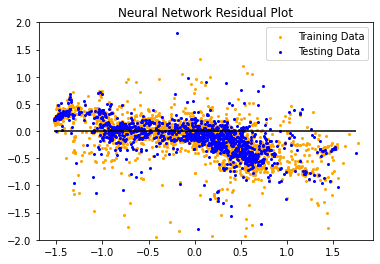

In [13]:
# Plot Residuals
import matplotlib.pyplot as plt

plt.title('Neural Network Residual Plot')
plt.scatter(predictions1, predictions1 - y_train_scaled, c= "orange",label="Training Data", s=4)
plt.scatter(predictions, predictions - y_test_scaled, c= "blue",label="Testing Data",s=4)
plt.ylim(-2,2)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.legend()

plt.savefig('neuralnetworkresidual.png')
plt.show()

In [14]:
# Score the prediction with mse and r2
from sklearn.metrics import mean_squared_error, r2_score
mse_train = mean_squared_error(y_train_scaled, predictions1)
r2_train = r2_score(y_train_scaled, predictions1)

In [15]:
mse_test = mean_squared_error(y_test_scaled, predictions)
r2_test = r2_score(y_test_scaled, predictions)

In [16]:
print(f"Mean Squared Error (MSE) Train Data: {mse_train}")
print(f"R-squared (R2) Train Data: {r2_train}")
print("-----------------------------------")
print(f"Mean Squared Error (MSE) Test Data: {mse_test}")
print(f"R-squared (R2) Test Data: {r2_test}")

Mean Squared Error (MSE) Train Data: 0.19237321368001045
R-squared (R2) Train Data: 0.8076267863199896
-----------------------------------
Mean Squared Error (MSE) Test Data: 0.18279156117870676
R-squared (R2) Test Data: 0.8141481540685934


# NEW Neural Network
